In [63]:
import kagglehub

path = kagglehub.dataset_download("noodulz/pokemon-dataset-1000")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/pokemon-dataset-1000


In [64]:
import os
import torch
from typing import List, Tuple, Dict, Optional
from dataclasses import dataclass
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import PIL
import PIL.Image as Image
import torchvision.transforms.functional as F
from pathlib import Path
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from torchvision.models import resnet50, ResNet50_Weights
import cv2

In [65]:
image_path = Path(path).joinpath("pokemon-dataset-1000")
test_dir = image_path.joinpath("test")
train_dir = image_path.joinpath("train")
val_dir = image_path.joinpath("val")

In [66]:
test_dir, train_dir, val_dir

(PosixPath('/kaggle/input/pokemon-dataset-1000/pokemon-dataset-1000/test'),
 PosixPath('/kaggle/input/pokemon-dataset-1000/pokemon-dataset-1000/train'),
 PosixPath('/kaggle/input/pokemon-dataset-1000/pokemon-dataset-1000/val'))

In [67]:
train_data = ImageFolder(test_dir)
test_data = ImageFolder(test_dir)
val_data = ImageFolder(val_dir)


In [68]:
@dataclass
class Config:
  batch_size:int = 32
  image_size:int = 224
  aug_prob:float = 0.5
  num_epochs:float = 20
  learning_rate:float = 1e-3
  num_classes:int = 1000
  weight_decay:float = 1e-2
  num_workers:int = 4
  device:str = 'cuda' if torch.cuda.is_available() else 'cpu'


config = Config()

In [69]:
import albumentations as A
class PokemonData(Dataset):

  def __init__(self, transform:Optional[A.Compose] = None, split:str = 'train', split_folder: str=train_data):
    self.transform = transform
    self.split = split

    self.image_folder = train_data
    self.classes = self.image_folder.classes
    self.class_to_idx = self.image_folder.class_to_idx
    self.images = self.image_folder.samples

  def __len__(self) -> int:
    return len(self.images)

  def __getitem__(self, idx:int) -> Tuple[torch.Tensor, int]:
    img_path, label = self.images[idx]
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    if self.transform:
      augmented = self.transform(image=image)
      image = augmented['image']

    return image, label

In [70]:
torch.multiprocessing.set_sharing_strategy('file_system')

In [71]:
from typing import Dict
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt


def get_transforms(config: Config) -> Dict[str, A.Compose]:
    train_transform = A.Compose([
        A.RandomRotate90(p=config.aug_prob),
        A.HorizontalFlip(p=config.aug_prob),
        A.VerticalFlip(p=config.aug_prob),
        A.ShiftScaleRotate(
            shift_limit=0.1,
            scale_limit=0.1,
            rotate_limit=45,
            p=config.aug_prob
        ),
        A.OneOf([
            A.RandomBrightnessContrast(
                brightness_limit=0.2,
                contrast_limit=0.2
            ),
            A.HueSaturationValue(
                hue_shift_limit=20,
                sat_shift_limit=30,
                val_shift_limit=20
            ),
        ], p=config.aug_prob),
        A.OneOf([
            A.GaussNoise(var_limit=(10.0, 50.0)),
            A.GaussianBlur(),
            A.MotionBlur()
        ], p=config.aug_prob),
        A.CoarseDropout(
            max_holes=8,
            max_height=16,
            max_width=16,
            fill_value=0,
            p=config.aug_prob
        ),
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
        ToTensorV2()
    ])

    val_transform = A.Compose([
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
        ToTensorV2()
    ])

    return {
        'train': train_transform,
        'test': val_transform,
        'val': val_transform
    }


def visualize_augmentations(
    dataset,
    transforms: A.Compose,
    num_examples: int = 10
) -> None:
    plt.figure(figsize=(4 * num_examples, 4))
    for i in range(num_examples):
        image, _ = dataset[i]
        augmented = transforms(image=image)['image']

        # Show original image
        plt.subplot(2, num_examples, i + 1)
        plt.imshow(image)
        plt.title('Original')
        plt.axis('off')

        # Show augmented image
        plt.subplot(2, num_examples, num_examples + i + 1)
        plt.imshow(augmented.permute(1, 2, 0))
        plt.title('Augmented')
        plt.axis('off')

    plt.show()


In [72]:
class Model(nn.Module):
  def __init__ (
      self,
      num_classes: int,
      pretrained: bool = True
  ):
    super().__init__()
    self.model = models.resnet50(weights=ResNet50_Weights.DEFAULT if pretrained else None)
    in_features = self.model.fc.in_features
    self.model.fc = nn.Sequential(
        nn.Dropout(0.3),
        nn.Linear(in_features,num_classes)
    )

  def forward(self, x):
    return self.model(x)

In [73]:
from tqdm.auto import tqdm
class EarlyStopping:
    def __init__(self, patience: int = 5, min_delta: float = 0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss: float) -> bool:
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        else:
            self.best_loss = val_loss
            self.counter = 0
        return False

class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val: float, n: int = 1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def train_epoch(
    model: nn.Module,
    loader: DataLoader,
    criterion: nn.Module,
    optimizer: optim.Optimizer,
    device: str,
    scheduler: Optional[optim.lr_scheduler._LRScheduler] = None,
    scaler: Optional[torch.cuda.amp.GradScaler] = None
) -> Tuple[float, float]:
    model.train()
    losses = AverageMeter()
    accuracies = AverageMeter()

    pbar = tqdm(loader, desc='Training')
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        batch_size = images.size(0)

        with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
            outputs = model(images)
            loss = criterion(outputs, labels)

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        acc = (outputs.argmax(1) == labels).float().mean()
        losses.update(loss.item(), batch_size)
        accuracies.update(acc.item(), batch_size)

        pbar.set_postfix({'loss': f'{losses.avg:.4f}', 'acc': f'{accuracies.avg:.4f}'})

    if scheduler is not None:
        scheduler.step()

    return losses.avg, accuracies.avg

def validate(
    model: nn.Module,
    criterion: nn.Module,
    loader: DataLoader,
    device: str
) -> Tuple[float, float]:
    model.eval()
    losses = AverageMeter()
    accuracies = AverageMeter()

    with torch.inference_mode():
        pbar = tqdm(loader, desc='Validation')

        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            batch_size = images.size(0)
            outputs = model(images)
            loss = criterion(outputs, labels)

            acc = (outputs.argmax(1) == labels).float().mean()
            losses.update(loss.item(), batch_size)
            accuracies.update(acc.item(), batch_size)

    return losses.avg, accuracies.avg


In [74]:
import logging

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datafmt = '%Y-%m-%d %H:%M:%S'
)
logger = logging.getLogger(__name__)


def train_model(config: Config) -> Dict[str, List[float]]:
    transforms = get_transforms(config)
    train_dataset = PokemonData(transform=transforms['train'], split='train', split_folder=train_data)
    test_dataset = PokemonData(transform=transforms['test'], split='test', split_folder=test_data)
    val_dataset = PokemonData(transform=transforms['val'], split='val', split_folder=val_data)

    train_loader = DataLoader(
        train_dataset,
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=config.num_workers,
        pin_memory=True,
        persistent_workers=True
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=config.batch_size,
        shuffle=False,
        num_workers=config.num_workers,
        pin_memory=True,
        persistent_workers=True
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=config.batch_size,
        shuffle=False,
        num_workers=config.num_workers,
        pin_memory=True,
        persistent_workers=True
    )

    model = Model(config.num_classes)
    model = model.to(config.device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(
        model.parameters(),
        lr=config.learning_rate,
        weight_decay=config.weight_decay
    )
    scaler = torch.amp.GradScaler()
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=config.learning_rate,
        epochs=config.num_epochs,
        steps_per_epoch=len(train_loader)
    )
    early_stopping = EarlyStopping(patience=3)
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    best_val_acc = 0
    for epoch in range(config.num_epochs):
        logger.info(f'Epoch {epoch+1}/{config.num_epochs}')
        train_loss, train_acc = train_epoch(
            model = model,
            loader = train_loader,
            criterion = criterion,
            optimizer = optimizer,
            scheduler= scheduler,
            device = config.device,
            scaler = scaler
        )
        val_loss, val_acc = validate(
            model,
            criterion,
            val_loader,
            config.device
        )
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        logger.info(
            f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
            f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}'
        )


        if early_stopping(val_loss):
            logger.info('Early stopping triggered')
            break

    return history


In [75]:
history = train_model(config)

Training:   0%|          | 0/102 [00:00<?, ?it/s]

Validation:   0%|          | 0/102 [00:00<?, ?it/s]

Training:   0%|          | 0/102 [00:00<?, ?it/s]

Validation:   0%|          | 0/102 [00:00<?, ?it/s]

Training:   0%|          | 0/102 [00:00<?, ?it/s]

Validation:   0%|          | 0/102 [00:00<?, ?it/s]

Training:   0%|          | 0/102 [00:00<?, ?it/s]

Validation:   0%|          | 0/102 [00:00<?, ?it/s]

Training:   0%|          | 0/102 [00:00<?, ?it/s]

Validation:   0%|          | 0/102 [00:00<?, ?it/s]

Training:   0%|          | 0/102 [00:00<?, ?it/s]

Validation:   0%|          | 0/102 [00:00<?, ?it/s]

Training:   0%|          | 0/102 [00:00<?, ?it/s]

Validation:   0%|          | 0/102 [00:00<?, ?it/s]

Training:   0%|          | 0/102 [00:00<?, ?it/s]

Validation:   0%|          | 0/102 [00:00<?, ?it/s]

Training:   0%|          | 0/102 [00:00<?, ?it/s]

Validation:   0%|          | 0/102 [00:00<?, ?it/s]

Training:   0%|          | 0/102 [00:00<?, ?it/s]

Validation:   0%|          | 0/102 [00:00<?, ?it/s]

Training:   0%|          | 0/102 [00:00<?, ?it/s]

Validation:   0%|          | 0/102 [00:00<?, ?it/s]

Training:   0%|          | 0/102 [00:00<?, ?it/s]

Validation:   0%|          | 0/102 [00:00<?, ?it/s]

Training:   0%|          | 0/102 [00:00<?, ?it/s]

Validation:   0%|          | 0/102 [00:00<?, ?it/s]

Training:   0%|          | 0/102 [00:00<?, ?it/s]

Validation:   0%|          | 0/102 [00:00<?, ?it/s]

Training:   0%|          | 0/102 [00:00<?, ?it/s]

Validation:   0%|          | 0/102 [00:00<?, ?it/s]

Training:   0%|          | 0/102 [00:00<?, ?it/s]

Validation:   0%|          | 0/102 [00:00<?, ?it/s]

Training:   0%|          | 0/102 [00:00<?, ?it/s]

Validation:   0%|          | 0/102 [00:00<?, ?it/s]

Training:   0%|          | 0/102 [00:00<?, ?it/s]

Validation:   0%|          | 0/102 [00:00<?, ?it/s]

Training:   0%|          | 0/102 [00:00<?, ?it/s]

Validation:   0%|          | 0/102 [00:00<?, ?it/s]

Training:   0%|          | 0/102 [00:00<?, ?it/s]

Validation:   0%|          | 0/102 [00:00<?, ?it/s]

In [76]:
history

{'train_loss': [6.920529098781622,
  6.821693375803284,
  6.523335592140935,
  5.9465709661546775,
  5.288349751375015,
  4.619499185785315,
  3.957655960117162,
  3.4013324395562807,
  2.8690194779614235,
  2.4349195072407266,
  2.0504808934539436,
  1.7137364219389937,
  1.4658053552121724,
  1.2363139239311514,
  1.0562779873232298,
  0.9195400570306781,
  0.8224573761417969,
  0.7119923692752124,
  0.5974320361701821,
  0.5533480318507576],
 'train_acc': [0.0006174745291756715,
  0.004013584439641865,
  0.018524235875270145,
  0.06637851188638469,
  0.14263661625338175,
  0.22599567767829576,
  0.3167644334809211,
  0.41309046009213296,
  0.5044766903917302,
  0.5825872183324526,
  0.6548317382184029,
  0.7199753010556373,
  0.7588761963937046,
  0.8209323866862727,
  0.8419265205862346,
  0.8706390862113055,
  0.8820623649826532,
  0.9039827107499875,
  0.9221982094710828,
  0.9320778019378936],
 'val_loss': [6.854726281715197,
  6.60696905444676,
  5.9991057198074875,
  5.2087219

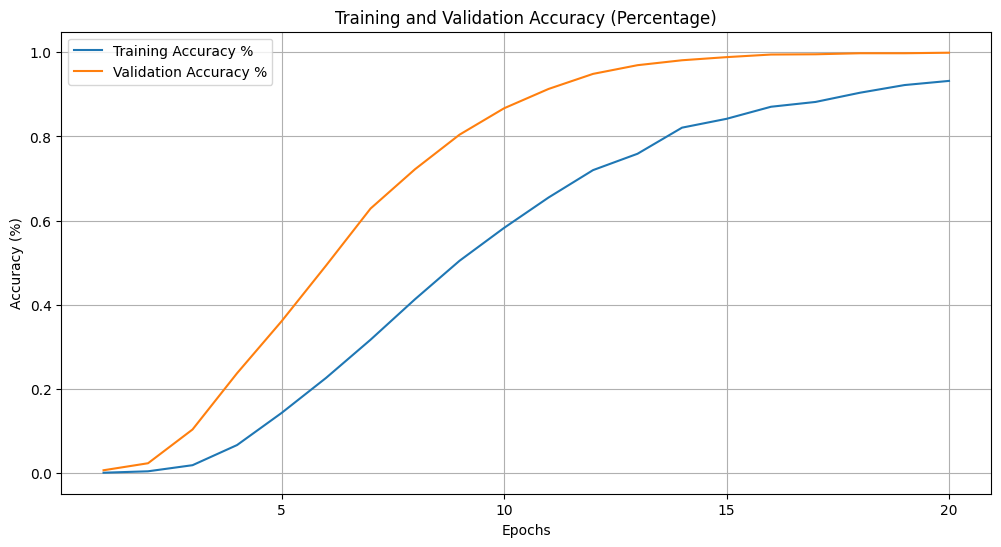

In [78]:
import matplotlib.pyplot as plt
x_ticks = [5,10,15,20]

epochs = list(range(1, len(history['train_acc']) + 1))
plt.figure(figsize=(12,6))
plt.plot(epochs, history['train_acc'], label="Training Accuracy %")
plt.plot(epochs, history['val_acc'], label="Validation Accuracy %")
plt.title('Training and Validation Accuracy (Percentage)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.xticks(x_ticks)  
plt.legend()
plt.grid(True)
plt.show()